# Computing PSD with Welch's 
Website used for reference:
[Compute the average bandpower of an EEG signal](https://raphaelvallat.com/bandpower.html)

In [13]:
import pickle
import numpy as np
import pandas as pd
from scipy import signal
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import simpson
import torch
from vit_pytorch import ViT
from vit_pytorch.cct import CCT, Tokenizer
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# load all raw data from DEAP dataset
x = pickle.load(open('data_preprocessed_python/s01.dat', 'rb'), encoding='latin1')
data = x['data']
labels = x['labels']

relevant_channels = data[:, :32, :]
relevant_labels = labels[:, :2]

print("Data shape after selecting first 32 channels:", relevant_channels.shape)
print("Labels shape:", relevant_labels.shape)


Data shape after selecting first 32 channels: (40, 32, 8064)
Labels shape: (40, 2)


In [3]:
# Organizing data into dataframes
labels_df = pd.DataFrame(relevant_labels, columns=['valence', 'arousal'])

trials_dfs = []
for i in range(40):
    eeg_df = pd.DataFrame(relevant_channels[i, :, :])
    trials_dfs.append(eeg_df)

Data shape: (32, 8064)
Frequencies shape: (1025,)
PSD shape: (32, 1025)


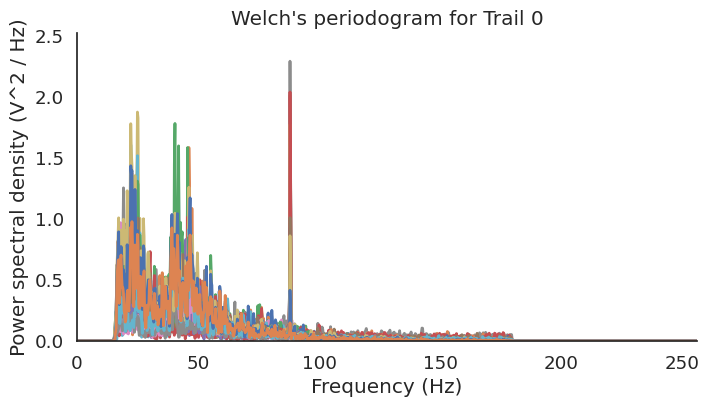

In [4]:
window_length = 4 * 512 # seconds * sample frequency
                        # seconds = two cycles of lowest frequency = 2/0.5 = 4
frequencies, psd = signal.welch(trials_dfs[0], 512, nperseg=window_length)

# example of using Welch's method to view PSD for all frequencies in first trial, first subject
print("Data shape:", trials_dfs[0].shape)
print("Frequencies shape:", frequencies.shape)
print("PSD shape:", psd.shape)
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
for channel_psd in psd:
    plt.plot(frequencies, channel_psd, lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram for Trail 0")
plt.xlim([0, frequencies.max()])
sns.despine()

## Subject-dependent model training
Training a ViT for each subject's data (with k-fold cross validation?),
Calculating **PSD** values for each subject and trial and putting it into one dataset

In [20]:
psd_data = [] # dataset with PSD data for all subjects and trials
for subject in range(32):
    file_path = f"data_preprocessed_python/s{subject + 1:02}.dat"
    x = pickle.load(open(file_path, 'rb'), encoding='latin1')
    data = x['data']
    labels = x['labels']
    relevant_channels = data[:, :32, :]
    relevant_labels = labels[:, :2]

    for i in range(40):
        eeg_df = pd.DataFrame(relevant_channels[i, :, :])
        window_length = 4 * 128
        frequencies, psd = signal.welch(eeg_df, 128, nperseg=window_length)
        
        # Keep full PSD (0.5-45.25Hz for 180 bins)
        valid_freq = (frequencies >= 4) & (frequencies <= 45)
        psd = psd[:, valid_freq]  # Shape: (32 channels, 180 freq bins)

        valence, arousal = relevant_labels[i][0], relevant_labels[i][1]
        classification = 0 if valence < 4.5 and arousal < 4.5 else \
                         1 if valence < 4.5 else \
                         2 if arousal < 4.5 else 3

        row = [subject+1, valence, arousal, classification]
        for j in range(32):
            row.extend(psd[j])
        
        psd_data.append(row)

columns = ['subject', 'valence', 'arousal', 'classification']
columns += [f'ch{j+1}_f{k}' for j in range(32) for k in range(165)]
psd_df = pd.DataFrame(psd_data, columns=columns)
psd_df

,subject,valence,arousal,classification,ch1_f0,ch1_f1,ch1_f2,ch1_f3,ch1_f4,ch1_f5,...,ch32_f155,ch32_f156,ch32_f157,ch32_f158,ch32_f159,ch32_f160,ch32_f161,ch32_f162,ch32_f163,ch32_f164
0,1,7.71,7.60,3,0.264969,0.795262,1.091772,0.915815,1.148149,1.338240,...,0.033147,0.029800,0.040905,0.036857,0.034799,0.028224,0.021061,0.024504,0.020067,0.009270
1,1,8.10,7.31,3,0.727819,1.102135,1.351511,1.848201,1.329333,1.454162,...,0.044488,0.052586,0.060338,0.069275,0.059571,0.036081,0.041196,0.048295,0.051495,0.019618
2,1,8.58,7.54,3,0.474737,1.135005,1.061324,1.155534,1.281670,1.582650,...,0.053887,0.076282,0.072202,0.062167,0.073178,0.057427,0.050839,0.062706,0.047246,0.020783
3,1,4.94,6.01,3,0.444635,0.837464,1.318595,1.816238,1.799792,1.521766,...,0.050341,0.045010,0.048988,0.032032,0.027982,0.037415,0.041918,0.027034,0.019459,0.010370
4,1,6.96,3.92,2,0.295010,0.631119,0.736735,0.647759,0.567012,0.767471,...,0.036012,0.040649,0.034647,0.027006,0.022398,0.026782,0.032363,0.030809,0.024796,0.010871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,32,3.91,6.96,1,0.853059,1.343258,1.433604,1.717798,1.442616,1.529830,...,0.131811,0.163277,0.152608,0.153042,0.118627,0.131633,0.134761,0.123732,0.077072,0.049150
1276,32,2.81,6.13,1,0.812092,1.769075,2.358448,2.162384,1.928233,1.792046,...,0.304163,0.285440,0.300953,0.288828,0.276072,0.259022,0.287030,0.268797,0.233294,0.107421
1277,32,3.05,7.01,1,0.964977,1.670244,1.408352,1.123765,1.466156,1.731756,...,0.217334,0.198718,0.176268,0.242905,0.235005,0.222300,0.246778,0.267827,0.248934,0.098351
1278,32,3.99,7.17,1,0.763055,1.400041,1.677561,1.368583,1.367377,1.963079,...,0.307011,0.230222,0.195105,0.228610,0.276826,0.313437,0.254524,0.316686,0.260357,0.100007


In [8]:
class EEGDataset(Dataset): # dataset object for pytorch
    def __init__(self, images, labels, device="cpu"):
        self.images = torch.tensor(images, dtype=torch.float32).to(device)
        self.labels = torch.tensor(labels, dtype=torch.long).to(device)
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [31]:
class CNNViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 5), padding=(1, 2)),
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, kernel_size=(3, 5), padding=(1, 2)),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.AdaptiveAvgPool2d((8, 41))
        )

        self.vit = ViT(
            image_size=(8, 41),
            patch_size=(2, 1),
            num_classes=4,
            dim=128,
            depth=4,
            heads=4,
            mlp_dim=256,
            channels=32,
            dropout=0.1,
            emb_dropout=0.1,
            pool='cls'
        )
    
    def forward(self, x):
        x = self.cnn(x)
        return self.vit(x)

In [32]:
subject_dependent_models = {} # dictionary containing models and data corresponding to each subject

for subject_id in range(1, 33):
    subject_data = psd_df[psd_df['subject'] == subject_id]
    psd_features = subject_data.iloc[:, 4:].values
    psd_images = psd_features.reshape(-1, 1, 32, 165)
    labels = subject_data['classification'].values

    train_images, test_images, train_labels, test_labels = train_test_split(
        psd_images, labels, test_size=0.2, random_state=42
    )
    train_images = train_images.astype(np.float32)
    test_images = test_images.astype(np.float32)
    train_dataset = EEGDataset(train_images, train_labels, device=device)
    test_dataset = EEGDataset(test_images, test_labels, device=device)
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    # vit = ViT(
    #     image_size=(32, 165),
    #     patch_size=(4, 5),
    #     num_classes=4,
    #     dim=128,
    #     depth=6,
    #     heads=8,
    #     mlp_dim=256,
    #     channels=1,
    #     dropout=0.1,
    #     emb_dropout=0.1,
    #     pool='cls'
    # ).to(device)
    vit = CNNViT().to(device)
    
    subject_dependent_models[subject_id] = {"model": vit, "train_loader": train_loader, "test_loader": test_loader}


In [37]:
# training and testing loop for each subject individually
for subject_id, data in subject_dependent_models.items():
    vit = data["model"]
    train_loader = data["train_loader"]
    test_loader = data["test_loader"]

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(vit.parameters(), lr=0.01)
    print(f"Training model for Subject {subject_id}...")

    # training
    for epoch in range(50):
        vit.train()
        for inputs, targets in train_loader:
            print(targets)
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad() # zero gradients for batch
            outputs = vit(inputs) # make precictions
            print(outputs)
            exit(0)
            loss = criterion(outputs, targets) # calculate loss and gradients from predictions
            loss.backward() 
            optimizer.step() # adjust learning weights
            print(f"\tSubject {subject_id} || Epoch {epoch + 1} || Loss: {loss.item()}", end='\r')

    #testing
    vit.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = vit(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        
    accuracy = 100 * correct / total
    print(f"Subject {subject_id}, Test Accuracy: {accuracy:.2f}%")
    print(f"Training complete for Subject {subject_id}.\n")

Training model for Subject 1...
tensor([1, 1, 0, 3, 0, 3, 0, 3], device='cuda:0')
tensor([[-0.5859, -0.0839, -1.0738, -0.1396],
        [-0.0168,  0.4995, -0.4725,  0.2624],
        [-0.0471,  0.4790, -0.5229,  0.3697],
        [-0.2869,  0.3801, -1.1724,  0.2981],
        [ 0.3465,  0.6484,  0.0590,  0.7974],
        [-0.0923,  0.3301, -0.6206,  0.2050],
        [ 0.1226,  0.5241, -0.0899,  0.6318],
        [ 0.3210,  0.7473, -0.3352,  0.4684]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([3, 2, 2, 1, 1, 3, 3, 1], device='cuda:0')
tensor([[ 0.7362,  0.0714, -1.1446,  1.1372],
        [ 0.5511,  0.0215, -1.1640,  1.1478],
        [ 0.7053,  0.0391, -1.0447,  1.1553],
        [ 0.6240, -0.0061, -1.1659,  1.1567],
        [ 0.6460, -0.0342, -1.1429,  1.1029],
        [ 0.6637, -0.0017, -0.9672,  1.1106],
        [ 0.7105,  0.1898, -0.9354,  1.0095],
        [ 0.7008,  0.0600, -0.9610,  1.0547]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([3, 1, 3, 2, 1, 0, 0, 3

tensor([[ 0.1029,  0.7136,  0.1315,  0.2079],
        [-0.1097,  0.5283,  0.2597,  0.1472],
        [ 0.1148,  0.7286,  0.2092,  0.3318],
        [ 0.0769,  0.6510,  0.3430,  0.2151],
        [ 0.0408,  0.6924,  0.2810,  0.2392],
        [ 0.1189,  0.7510,  0.3621,  0.2667],
        [ 0.0367,  0.7606,  0.3511,  0.2135],
        [-0.0024,  0.6476,  0.2863,  0.4179]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([3, 2, 0, 3, 3, 3, 0, 1], device='cuda:0')
tensor([[ 0.1212,  0.7607,  0.4267,  0.5695],
        [-0.0211,  0.6914,  0.6004,  0.4733],
        [-0.1451,  0.6438,  0.2544,  0.3053],
        [ 0.0365,  0.7199,  0.4133,  0.3174],
        [-0.0015,  0.6940,  0.5455,  0.4344],
        [-0.0206,  0.7208,  0.3709,  0.3918],
        [ 0.1373,  0.7391,  0.4324,  0.6447],
        [ 0.0281,  0.6662,  0.3602,  0.4321]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 3, 0, 1, 3], device='cuda:0')
tensor([[-0.0268,  0.2053, -0.0166,  0.2543],
        [ 0.1557

KeyboardInterrupt: 

: 